In [1]:
!pip install -q --upgrade pip
!pip install -U jaxlib==0.4.2+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.25+cuda11.cudnn805
    Uninstalling jaxlib-0.3.25+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.25+cuda11.cudnn805
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK


In [2]:
from utils import *
import os

from sklearn import metrics
import neural_tangents as nt
from neural_tangents import stax
from jax import numpy as np
from jax import random
import jax
from jax import numpy as np
from jax import jit, grad, vmap
from jax.example_libraries import optimizers
from jax import random
import matplotlib.pyplot as plt
from jax.nn import log_softmax


In [54]:
def balance(ys):
  one_indices = np.array(np.nonzero(ys))[0,:]
  zero_indices = np.array(np.nonzero(ys==0))[0,:]

  one_count = int(one_indices.shape[0])
  zero_count = int(zero_indices.shape[0])

  if one_count > zero_count:
    one_indices = one_indices[:zero_count]
  else:
    zero_indices = zero_indices[:one_count]

  indices = np.append(one_indices, zero_indices)

  # shuffel the indices
  key = random.PRNGKey(0)
  key, subkey = jax.random.split(key)
  indices = random.permutation(subkey, indices)

  return indices

In [85]:
# load preprocessed data

dataset_name = "MUTAG"
base_path = f"/content/drive/MyDrive/MasterarbeitData/Preprocessed/{dataset_name}"

ys = np.load(base_path + f"/ys.npy")
graps_node_features = np.load(base_path + f"/graps_node_features.npy")
graph_conv_pattern = np.load(base_path + f"/graph_conv_pattern.npy")

# shouldnt this be 
# batch x #nodes x 1 x #channels ?
print(graps_node_features.shape)
print(graph_conv_pattern.shape)

(188, 28, 7, 1)
(188, 28, 7, 28, 7)


In [147]:
# reshape to:
# batch x #nodes x 1 x #channels
# we need the 1 in axis 2, that we can use convolution layer
graps_node_features_t = np.swapaxes(graps_node_features, 2, 3)
graps_node_features_t.shape

(188, 28, 1, 7)

In [148]:
# addapt the pattern!
graph_conv_pattern_t = graph_conv_pattern[:, :, 1, :, 1]
graph_conv_pattern_t = np.expand_dims(graph_conv_pattern_t, 2)
graph_conv_pattern_t = np.expand_dims(graph_conv_pattern_t, 4)
graph_conv_pattern_t.shape

(188, 28, 1, 28, 1)

In [153]:
graph_conv_pattern = graph_conv_pattern_t
graps_node_features = graps_node_features_t

In [149]:
# split the data into folds for cross validation
key = random.PRNGKey(0)
key, subkey = jax.random.split(key)
batch_index = np.squeeze(random.randint(subkey, (188,1), 0, 10))

In [196]:
layer_wide = 32
# define a grap convolution network
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Aggregate(aggregate_axis=(1,2), batch_axis=0, channel_axis=3),
    stax.Conv(layer_wide, (1,1), parameterization="standard"), stax.Relu(),
    stax.Aggregate(aggregate_axis=(1, 2), batch_axis=0, channel_axis=3),
    stax.Conv(layer_wide, (1,1), parameterization="standard"), stax.Relu(),
    stax.Aggregate(aggregate_axis=(1, 2), batch_axis=0, channel_axis=3),
    stax.Conv(layer_wide, (1,1), parameterization="standard"), stax.Relu(),
    stax.Aggregate(aggregate_axis=(1, 2), batch_axis=0, channel_axis=3),
    #stax.Aggregate(aggregate_axis=(1, 2), batch_axis=0, channel_axis=3),
    #stax.Conv(layer_wide, (1,1), parameterization="standard"), stax.Relu(),
    #stax.Aggregate(aggregate_axis=(1, 2), batch_axis=0, channel_axis=3),
    #stax.Conv(layer_wide, (1,1), parameterization="standard"), stax.Relu(),
    stax.GlobalSumPool(),
    stax.Dense(1),
)

In [197]:
def accuracy(ys, logits):
  return np.mean((logits > 0) == ys)

def cross_entropy(ys, logits):
  log_p = jax.nn.log_sigmoid(logits)
  log_not_p = jax.nn.log_sigmoid(-logits)
  return np.mean(-ys * log_p - (1 - ys) * log_not_p)

loss = jit(cross_entropy)
grad_loss = jit(grad(lambda params, x, y, pattern: loss(y, apply_fn(params, x, pattern=pattern))))

In [208]:
# initialize the paramters and the optimzer 
learning_rate =  0.0001

key, subkey = jax.random.split(key)
_, params = init_fn(subkey, graps_node_features_t.shape)

opt_init, opt_apply, get_params = optimizers.adam(learning_rate)
opt_apply = jit(opt_apply)
state = opt_init(params)

In [209]:
epochs = 500

train_losses = []
val_losses = []
params_evolution = []
val_acc = []

for epoch in range(epochs):
  print(epoch)

  key, subkey = jax.random.split(key)
  hold_out_batch = np.squeeze(random.randint(subkey, (1,1), 0, 10))
  hold_out_indx = hold_out_batch == batch_index

  xs_val = graps_node_features[hold_out_indx,:]
  pattern_val = graph_conv_pattern[hold_out_indx,:]
  ys_val = ys[hold_out_indx,:]

  xs_train = graps_node_features[~hold_out_indx,:]
  pattern_train = graph_conv_pattern[~hold_out_indx,:]
  ys_train = ys[~hold_out_indx,:]

  # # balance the classes for the traig
  # balanced_indices_train = balance(ys_train)
  # xs_train = xs_train[balanced_indices_train,:]
  # pattern_train = pattern_train[balanced_indices_train,:]
  # ys_train = ys_train[balanced_indices_train,:]

  params = get_params(state)
  params_evolution.append(params)
  state = opt_apply(epoch, grad_loss(params, xs_train, ys_train, pattern_train), state)

  params = get_params(state)
  train_losses += [loss(ys_train, apply_fn(params, xs_train, pattern=pattern_train))]
  val_losses += [loss(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]
  #val_auc += [metrics.roc_auc_score(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]
  val_acc += [accuracy(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

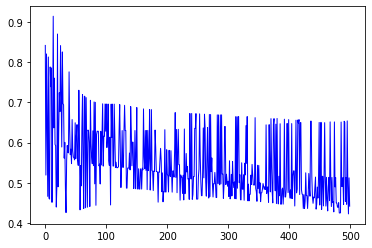

In [207]:
plt.plot(np.array(range(epochs)), np.array(val_losses), 'b-', linewidth=1)

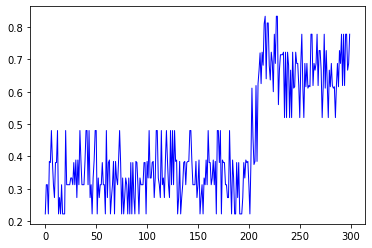

In [201]:
plt.plot(np.array(range(epochs)), np.array(val_acc), 'b-', linewidth=1)

In [202]:
np.mean(np.array(val_acc[-10:]))

Array(0.716865, dtype=float32)

In [193]:
accuracy(ys_val, apply_fn(params, xs_val, pattern=pattern_val))

Array(0.6875, dtype=float32)

In [59]:
np.mean(ys_train)

Array(0.5, dtype=float32)

In [83]:
epochs = 200
train_losses = []
val_losses = []
params_evolution = []
val_auc = []

for epoch in range(epochs):
  print(epoch)

  key, subkey = jax.random.split(key)
  hold_out_batch = np.squeeze(random.randint(subkey, (1,1), 0, 10))
  hold_out_indx = hold_out_batch == batch_index

  xs_val = graps_node_features[hold_out_indx,:]
  pattern_val = graph_conv_pattern[hold_out_indx,:]
  ys_val = ys[hold_out_indx,:]

  for i in range(10):
    if i == int(hold_out_batch):
      next

    batch_indx = i == batch_index
    
    xs_train = graps_node_features[batch_indx,:]
    pattern_train = graph_conv_pattern[batch_indx,:]
    ys_train = ys[batch_indx,:]

    params = get_params(state)
    params_evolution.append(params)
    state = opt_apply(i, grad_loss(params, xs_train, ys_train, pattern_train), state)

  params = get_params(state)
  train_losses += [loss(ys_train, apply_fn(params, xs_train, pattern=pattern_train))]
  val_losses += [loss(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]
  val_auc += [metrics.roc_auc_score(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [65]:
np.mean((params_evolution[0][1][0] - params_evolution[80][1][0])**2)

Array(0.00014, dtype=float32)

In [40]:
ys_val

Array([[0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [24]:
y_hat.shape

(16, 1)

In [25]:
ys_train.shape

(21, 1)

In [66]:
loss(ys_val, y_hat)

Array(1.9280187, dtype=float32)

In [ ]:
cross_entropy = lambda fx, y_hat: -np.mean(log_softmax(fx) * y_hat)

In [32]:
-(ys_val*np.log(y_hat) + (1-ys_val)*np.log(1-y_hat))

Array([[0.18160222],
       [2.4145052 ],
       [2.2848625 ],
       [2.1505697 ],
       [3.4824953 ],
       [0.12298561],
       [2.2913272 ],
       [0.1816594 ],
       [2.5637712 ],
       [1.689944  ],
       [3.471296  ],
       [2.6953633 ],
       [0.07056083],
       [2.996308  ],
       [4.01879   ],
       [0.23225985]], dtype=float32)

In [30]:
log_softmax(y_hat)

Array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)